In [1]:
# need to do this before transformer imports
import os
os.environ['HF_HOME'] = '/workspace/cache/huggingface/'

In [2]:
import os
os.chdir('/workspace/FutureGPT2/src/')
from evals.utils import *
from models.bigram_model import *
from models.mlp_model import *
from models.future_model import *
from data.utils import get_tokenizer, get_loader
import datasets
from torch.utils.data import DataLoader
from torch import nn
from itertools import islice
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset
from matplotlib import pyplot as plt

from tqdm import tqdm
import pandas as pd
import gc
from glob import glob
from collections import defaultdict

%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
ds_names = [
    'rand',
    'ArXiv',
    'Enron Emails',
    'FreeLaw',
    'HackerNews',
    'OpenSubtitles',
    'PubMed Abstracts',
    'UPSTO Backgrounds',
    #'DM Mathematics',
    'EuroParl',
    'Github',
    #'NIH ExPorter',
    'OpenWebText2',
    'StackExchange',
    'Wikipedia (en)',
    'YoutubeSubtitles',
]

ds_short_names = [
    'rand',
    'ArXiv',
    'Enron',
    'FreeLaw',
    'HackerNews',
    'OpenSubs',
    'PubMed',
    'UPSTO',
    #'DM Math',
    'EuroParl',
    'Github',
    #'NIH',
    'OWebText',
    'StackEx.',
    'Wikipedia',
    'Youtube',
]

In [5]:
tokenizer = get_tokenizer('mistralai/Mistral-7B-v0.1')

In [6]:
def get_model(ds_name):
    ckpt = glob(f'/workspace/checkpoints/MISTRAL-PILE-SWEEP_*_dataset_name-{ds_name}_hidden_idxs-31_hidden_lb-0_neck_cls-mlp_token_lb-0_*.ckpt')[0]
    return LitFutureModelWithNeck.load_from_checkpoint(ckpt, strict=False)

In [7]:
def to_cuda(batch):
    for k in ['input_ids', 'attention_mask']:
        batch[k] = batch[k].to('cuda')
    return batch

In [ ]:
for ds_name in ds_names:
    print(ds_name)
    loader = get_loader(ds_name, 'MISTRAL', shuffle=True)['val']
    sample = next(iter(loader))
    if 'text' in sample:
        for i in range(5):
            print(sample['text'][i])
    else:
        for i in range(5):
            print(tokenizer.decode(sample['input_ids'][i]))
    print('\n\n')

In [18]:
#loss_d = defaultdict(dict)
nbatch = 10
for name in ds_names:
    print('MODEL', name)
    if name in loss_d:
        print('done already; skipping...')
        continue
    model = get_model(name)
    for ds_name in ds_names:
        print('DATA', ds_name)
        loader = get_loader(ds_name, 'MISTRAL')['test']
        with torch.no_grad():
            losses = [
                model._compute_loss(to_cuda(batch)) 
                for batch in tqdm(islice(iter(loader), nbatch), total=nbatch)
            ]
        mean_losses = {}
        for k in ['base_loss', 'self_loss', 'future_loss']:
            mean_losses[k] = np.mean([x[k].item() for x in losses])
            print(k, mean_losses[k])
        print('')
        loss_d[name][ds_name] = mean_losses
        gc.collect()
        torch.cuda.empty_cache()
    print('\n-------------------------')

MODEL rand
done already; skipping...
MODEL ArXiv
done already; skipping...
MODEL Enron Emails
done already; skipping...
MODEL FreeLaw
done already; skipping...
MODEL HackerNews
done already; skipping...
MODEL OpenSubtitles
done already; skipping...
MODEL PubMed Abstracts
done already; skipping...
MODEL UPSTO Backgrounds
done already; skipping...
MODEL EuroParl


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

DATA rand


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


base_loss 12.609772205352783
self_loss 9.450024604797363
future_loss 12.11408748626709

DATA ArXiv


100%|██████████| 10/10 [01:04<00:00,  6.47s/it]


base_loss 2.5708272218704225
self_loss 6.697222900390625
future_loss 6.76674599647522

DATA Enron Emails


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.9236831426620484
self_loss 5.9757468700408936
future_loss 5.987446117401123

DATA FreeLaw


100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


base_loss 2.011677098274231
self_loss 5.794210481643677
future_loss 5.816886043548584

DATA HackerNews


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 2.950989270210266
self_loss 6.355399799346924
future_loss 6.442558336257934

DATA OpenSubtitles


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.9496663331985475
self_loss 6.428401708602905
future_loss 6.4963373184204105

DATA PubMed Abstracts


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.25937819480896
self_loss 6.459711360931396
future_loss 6.468631601333618

DATA UPSTO Backgrounds


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 2.412792372703552
self_loss 6.250338935852051
future_loss 6.313852071762085

DATA EuroParl


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.658074951171875
self_loss 4.3645094871521
future_loss 4.193184232711792

DATA Github


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 1.5997249245643617
self_loss 7.077572441101074
future_loss 7.099651861190796

DATA OpenWebText2


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.4773062467575073
self_loss 6.155214548110962
future_loss 6.143601369857788

DATA StackExchange


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.3796822786331178
self_loss 6.600138187408447
future_loss 6.6208781719207765

DATA Wikipedia (en)


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


base_loss 2.102554774284363
self_loss 5.843559122085571
future_loss 5.826313781738281

DATA YoutubeSubtitles


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 2.6938875675201417
self_loss 6.518565225601196
future_loss 6.530020093917846


-------------------------
MODEL Github


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

DATA rand


100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


base_loss 12.607874870300293
self_loss 9.418622589111328
future_loss 12.234964179992676

DATA ArXiv


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 2.5649524927139282
self_loss 6.080328130722046
future_loss 6.121433973312378

DATA Enron Emails


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 2.9067813873291017
self_loss 5.462105655670166
future_loss 5.449272537231446

DATA FreeLaw


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.021521818637848
self_loss 5.3770801544189455
future_loss 5.40641222000122

DATA HackerNews


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.9718191385269166
self_loss 5.57703161239624
future_loss 5.655372095108032

DATA OpenSubtitles


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 2.9453783512115477
self_loss 6.230819416046143
future_loss 6.29132194519043

DATA PubMed Abstracts


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.2377792596817017
self_loss 6.436924982070923
future_loss 6.469297170639038

DATA UPSTO Backgrounds


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 2.4354706048965453
self_loss 5.95367021560669
future_loss 6.011403226852417

DATA EuroParl


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.670064091682434
self_loss 7.2515456199646
future_loss 7.3296130180358885

DATA Github


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


base_loss 1.6291857361793518
self_loss 3.2758490800857545
future_loss 3.200408148765564

DATA OpenWebText2


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.5029803991317747
self_loss 6.331046724319458
future_loss 6.347858333587647

DATA StackExchange


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.3986806154251097
self_loss 4.81259446144104
future_loss 4.832698249816895

DATA Wikipedia (en)


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.1320387363433837
self_loss 6.069120836257935
future_loss 6.0720631122589115

DATA YoutubeSubtitles


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.698017978668213
self_loss 6.174111795425415
future_loss 6.1561380386352536


-------------------------
MODEL OpenWebText2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

DATA rand


100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


base_loss 12.611029243469238
self_loss 9.278848457336426
future_loss 12.014416408538818

DATA ArXiv


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.570257329940796
self_loss 5.814775466918945
future_loss 5.887636184692383

DATA Enron Emails


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.898630380630493
self_loss 5.217693138122558
future_loss 5.262023019790649

DATA FreeLaw


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.0204559564590454
self_loss 4.7691662311553955
future_loss 4.832333326339722

DATA HackerNews


100%|██████████| 10/10 [01:05<00:00,  6.52s/it]


base_loss 2.947096514701843
self_loss 5.148109245300293
future_loss 5.290211534500122

DATA OpenSubtitles


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.958215022087097
self_loss 5.140316534042358
future_loss 5.212938022613526

DATA PubMed Abstracts


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.2397485256195067
self_loss 5.312975454330444
future_loss 5.322819566726684

DATA UPSTO Backgrounds


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.453390049934387
self_loss 5.058354377746582
future_loss 5.112974500656128

DATA EuroParl


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.6510491132736207
self_loss 5.970545673370362
future_loss 6.026632499694824

DATA Github


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 1.6316112875938416
self_loss 6.015273809432983
future_loss 6.038295650482178

DATA OpenWebText2


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 2.482914423942566
self_loss 4.78304762840271
future_loss 4.766031265258789

DATA StackExchange


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.3661785364151
self_loss 5.405162715911866
future_loss 5.419070720672607

DATA Wikipedia (en)


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


base_loss 2.1008248329162598
self_loss 4.752967023849488
future_loss 4.726314735412598

DATA YoutubeSubtitles


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.727144694328308
self_loss 5.468693351745605
future_loss 5.53377776145935


-------------------------
MODEL StackExchange


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

DATA rand


100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


base_loss 12.614516258239746
self_loss 9.260636329650879
future_loss 11.998633289337159

DATA ArXiv


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.5807750463485717
self_loss 5.5164612293243405
future_loss 5.572854709625244

DATA Enron Emails


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.9042343139648437
self_loss 5.271824741363526
future_loss 5.255725955963134

DATA FreeLaw


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 1.9748148798942566
self_loss 5.237486934661865
future_loss 5.2592250347137455

DATA HackerNews


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.948735785484314
self_loss 5.119993686676025
future_loss 5.211109781265259

DATA OpenSubtitles


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.9370522260665894
self_loss 5.551930665969849
future_loss 5.61945333480835

DATA PubMed Abstracts


100%|██████████| 10/10 [01:05<00:00,  6.52s/it]


base_loss 2.2564154386520388
self_loss 5.8867450714111325
future_loss 5.904131746292114

DATA UPSTO Backgrounds


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 1.6256154537200929
self_loss 4.379652595520019
future_loss 4.389791774749756

DATA OpenWebText2


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.4806681871414185
self_loss 5.779811668395996
future_loss 5.787967157363892

DATA StackExchange


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.3711385250091555
self_loss 4.077327752113343
future_loss 4.093248128890991

DATA Wikipedia (en)


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.090390610694885
self_loss 5.64976315498352
future_loss 5.650333881378174

DATA YoutubeSubtitles


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.7045023918151854
self_loss 5.78324408531189
future_loss 5.782490205764771


-------------------------
MODEL Wikipedia (en)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

DATA rand


100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


base_loss 12.609022331237792
self_loss 9.488430881500244
future_loss 12.436226654052735

DATA ArXiv


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.5695367813110352
self_loss 5.756282472610474
future_loss 5.808628225326538

DATA Enron Emails


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.9194095849990847
self_loss 5.414036846160888
future_loss 5.4574892044067385

DATA FreeLaw


100%|██████████| 10/10 [01:05<00:00,  6.52s/it]


base_loss 1.9856808662414551
self_loss 4.851907873153687
future_loss 4.891486549377442

DATA HackerNews


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.9534039735794066
self_loss 5.540811920166016
future_loss 5.667178726196289

DATA OpenSubtitles


100%|██████████| 10/10 [01:05<00:00,  6.52s/it]


base_loss 2.9663853883743285
self_loss 5.649982213973999
future_loss 5.686765241622925

DATA PubMed Abstracts


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.2207385301589966
self_loss 5.207229900360107
future_loss 5.22141170501709

DATA UPSTO Backgrounds


100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


base_loss 2.423734426498413
self_loss 5.033701419830322
future_loss 5.070119571685791

DATA EuroParl


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.6055249691009523
self_loss 6.799044561386109
future_loss 6.88480863571167

DATA Github


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 1.622618556022644
self_loss 6.3909587383270265
future_loss 6.414370536804199

DATA OpenWebText2


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


base_loss 2.4772159337997435
self_loss 5.344767427444458
future_loss 5.342165517807007

DATA StackExchange


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.3435803413391114
self_loss 5.913616418838501
future_loss 5.932120752334595

DATA Wikipedia (en)


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.118670701980591
self_loss 4.221578454971313
future_loss 4.142618346214294

DATA YoutubeSubtitles


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.731733703613281
self_loss 6.102199220657349
future_loss 6.141647386550903


-------------------------
MODEL YoutubeSubtitles


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

DATA rand


100%|██████████| 10/10 [01:04<00:00,  6.43s/it]


base_loss 12.610803699493408
self_loss 9.617036247253418
future_loss 12.439642333984375

DATA ArXiv


100%|██████████| 10/10 [01:04<00:00,  6.48s/it]


base_loss 2.5639728784561155
self_loss 5.821093034744263
future_loss 5.894502735137939

DATA Enron Emails


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.9258381128311157
self_loss 5.304451179504395
future_loss 5.2826550006866455

DATA FreeLaw


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.0024445772171022
self_loss 4.949343824386597
future_loss 4.955061340332032

DATA HackerNews


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.943840837478638
self_loss 5.292988109588623
future_loss 5.373766803741455

DATA OpenSubtitles


100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


base_loss 2.9663429260253906
self_loss 5.21792459487915
future_loss 5.299051094055176

DATA PubMed Abstracts


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.2394967794418337
self_loss 5.641010665893555
future_loss 5.654184055328369

DATA UPSTO Backgrounds


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.4311834573745728
self_loss 5.233812999725342
future_loss 5.281653881072998

DATA EuroParl


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.615047287940979
self_loss 5.864946365356445
future_loss 5.875513887405395

DATA Github


100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


base_loss 1.6154364824295044
self_loss 6.246255731582641
future_loss 6.258156633377075

DATA OpenWebText2


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


base_loss 2.456416702270508
self_loss 5.26663613319397
future_loss 5.251882410049438

DATA StackExchange


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.413292670249939
self_loss 5.613999509811402
future_loss 5.620232677459716

DATA Wikipedia (en)


100%|██████████| 10/10 [01:04<00:00,  6.49s/it]


base_loss 2.0880893230438233
self_loss 5.124447011947632
future_loss 5.099967002868652

DATA YoutubeSubtitles


100%|██████████| 10/10 [01:05<00:00,  6.52s/it]


base_loss 2.714850401878357
self_loss 4.665845060348511
future_loss 4.537787342071534


-------------------------


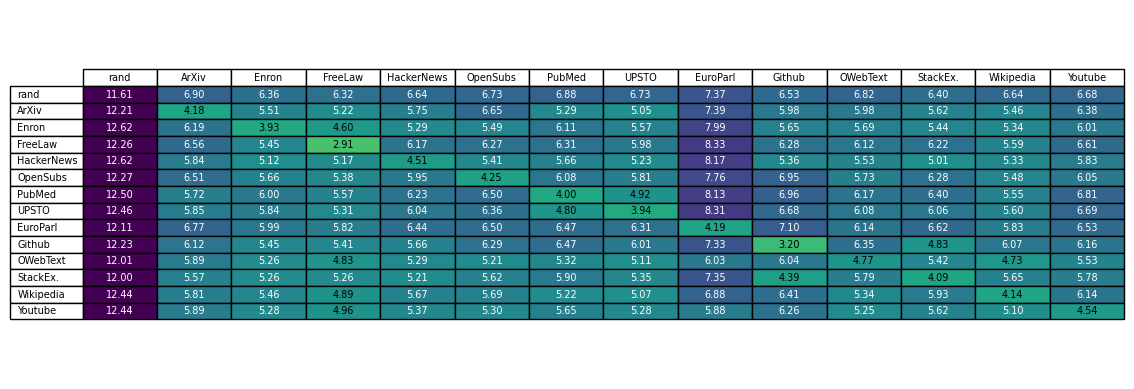

In [25]:
loss = [
    [loss_d[model][ds]["future_loss"] for ds in ds_names]
    for model in ds_names
]
loss_str = [
    [f'{loss[i][j]:.2f}' for j in range(len(loss[i]))] 
    for i in range(len(loss))
]

fig, ax = plt.subplots()
table = ax.table(
    cellText=loss_str, 
    loc='center', 
    cellLoc='center', 
    colWidths=[0.15 for _ in range(len(loss))],
    colLabels=ds_short_names,
    rowLabels=ds_short_names,
)

for i in range(len(loss)):
    for j in range(len(loss[0])):
        color = plt.cm.viridis(1 - loss[i][j] / 10)
        table[(i+1, j)].set_facecolor(color)
        if loss[i][j] > 5:
            table[(i+1, j)].set_text_props(color='white')
ax.axis('off')
plt.show()

In [10]:
list(loss_d.keys())

['rand',
 'ArXiv',
 'Enron Emails',
 'FreeLaw',
 'HackerNews',
 'OpenSubtitles',
 'PubMed Abstracts',
 'UPSTO Backgrounds']

In [24]:
import pickle
with open ('data_transfer_losses.pickle', 'wb') as f:
    pickle.dump(loss_d, f)

In [15]:
with open ('data_transfer_losses.pickle', 'rb') as f:
    b = pickle.load(f)

In [16]:
b

defaultdict(dict,
            {'rand': {'rand': {'base_loss': 12.6141752243042,
               'self_loss': 8.290161323547363,
               'future_loss': 11.614474678039551},
              'ArXiv': {'base_loss': 2.5654716014862062,
               'self_loss': 6.831877374649048,
               'future_loss': 6.897280311584472},
              'Enron Emails': {'base_loss': 2.9089842081069945,
               'self_loss': 6.4353344440460205,
               'future_loss': 6.360086250305176},
              'FreeLaw': {'base_loss': 2.028987205028534,
               'self_loss': 6.311294269561768,
               'future_loss': 6.315077018737793},
              'HackerNews': {'base_loss': 2.959638524055481,
               'self_loss': 6.600970935821533,
               'future_loss': 6.636679792404175},
              'OpenSubtitles': {'base_loss': 2.9538165092468263,
               'self_loss': 6.753598356246949,
               'future_loss': 6.726288747787476},
              'PubMed Abstracts